In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imshow

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import keras
import tensorflow as tf
from keras import backend as K
import innvestigate
import innvestigate.utils
from keras.applications.vgg16 import preprocess_input
import PIL.Image
#}

Using TensorFlow backend.


In [2]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU (for TensorFlow 1.X + Keras)
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# confirm PyTorch sees the GPU
#from torch import cuda
#assert cuda.is_available()
#assert cuda.device_count() > 0
#print(cuda.get_device_name(cuda.current_device()))


Model architecture
<img src="../../data/misc/vgg16.png">

In [3]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [4]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        '''
        img = imread(im_path,as_gray=False, pilmode="RGB")
        #print im_path
        #print img.shape
        if img_size:
            img = resize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)
        '''
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        #ret[:, :, 0] -= 123.68
        #ret[:, :, 1] -= 116.779
        #ret[:, :, 2] -= 103.939
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        x = preprocess_input(ret)
        img_list.append(x)
        

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [5]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [9]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [11]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

In [12]:
backend.image_data_format()

'channels_last'

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from keras import layers
from keras import models
import keras.utils as keras_utils
from keras.layers import Lambda

from  keras.applications import imagenet_utils
from  keras.applications.imagenet_utils import decode_predictions
from  keras_applications.imagenet_utils import _obtain_input_shape

preprocess_input = imagenet_utils.preprocess_input

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.1/'
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.1/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


def VGG16(include_top=True,
          weights='imagenet',
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=1000,
          lambda_mask=None,
          **kwargs):
    
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = tf.keras.utils
    
    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    
    if lambda_mask is not None:
        block_1_conv_1_mask  = np.reshape(lambda_mask[0:3211264], (224, 224,64))
    else:
        block_1_conv_1_mask = np.ones(shape=((224, 224, 64)))
    
    block_1_conv_1_mask  = backend.variable(block_1_conv_1_mask)
    block_1_conv_1_lambda = Lambda(lambda x: x * block_1_conv_1_mask)(x)
    
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(block_1_conv_1_lambda)
    
    if lambda_mask is not None:
        block_1_conv_2_mask  = np.reshape(lambda_mask[3211264:6422528], (224, 224, 64))
    else:
        block_1_conv_2_mask = np.ones(shape=((224, 224, 64)))
    
    block_1_conv_2_mask  = backend.variable(block_1_conv_2_mask)
    block_1_conv_2_lambda = Lambda(lambda x: x * block_1_conv_2_mask)(x)
    
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(block_1_conv_2_lambda)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    
    if lambda_mask is not None:
        block_2_conv_1_mask  = np.reshape(lambda_mask[6422528:8028160], (112, 112, 128))
    else:
        block_2_conv_1_mask = np.ones(shape=((112, 112, 128)))
    
    block_2_conv_1_mask  = backend.variable(block_2_conv_1_mask)
    block_2_conv_1_lambda = Lambda(lambda x: x * block_2_conv_1_mask)(x)
    
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(block_2_conv_1_lambda)
    
    
    if lambda_mask is not None:
        block_2_conv_2_mask  = np.reshape(lambda_mask[8028160:9633792], (112, 112, 128))
    else:
        block_2_conv_2_mask = np.ones(shape=((112, 112, 128)))
    
    block_2_conv_2_mask  = backend.variable(block_2_conv_2_mask)
    block_2_conv_2_lambda = Lambda(lambda x: x * block_2_conv_2_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(block_2_conv_2_lambda)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    
    if lambda_mask is not None:
        block_3_conv_1_mask  = np.reshape(lambda_mask[9633792:10436608], (56, 56, 256))
    else:
        block_3_conv_1_mask = np.ones(shape=((56, 56, 256)))
    
    block_3_conv_1_mask  = backend.variable(block_3_conv_1_mask)
    block_3_conv_1_lambda = Lambda(lambda x: x * block_3_conv_1_mask)(x)
    
    
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(block_3_conv_1_lambda)
    
    if lambda_mask is not None:
        block_3_conv_2_mask  = np.reshape(lambda_mask[10436608:11239424], (56, 56, 256))
    else:
        block_3_conv_2_mask = np.ones(shape=((56, 56, 256)))
    
    block_3_conv_2_mask  = backend.variable(block_3_conv_2_mask)
    block_3_conv_2_lambda = Lambda(lambda x: x * block_3_conv_2_mask)(x)
    
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')( block_3_conv_2_lambda)
    
    if lambda_mask is not None:
        block_3_conv_3_mask  = np.reshape(lambda_mask[11239424:12042240], (56, 56, 256))
    else:
        block_3_conv_3_mask = np.ones(shape=((56, 56, 256)))
    
    block_3_conv_3_mask  = backend.variable(block_3_conv_3_mask)
    block_3_conv_3_lambda = Lambda(lambda x: x * block_3_conv_3_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(block_3_conv_3_lambda)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    
    if lambda_mask is not None:
        block_4_conv_1_mask  = np.reshape(lambda_mask[12042240:12443648], (28, 28, 512))
    else:
        block_4_conv_1_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_1_mask  = backend.variable(block_4_conv_1_mask)
    block_4_conv_1_lambda = Lambda(lambda x: x * block_4_conv_1_mask)(x)
    
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(block_4_conv_1_lambda)
    
    if lambda_mask is not None:
        block_4_conv_2_mask  = np.reshape(lambda_mask[12443648:12845056], (28, 28, 512))
    else:
        block_4_conv_2_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_2_mask  = backend.variable(block_4_conv_2_mask)
    block_4_conv_2_lambda = Lambda(lambda x: x * block_4_conv_2_mask)(x)
    
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(block_4_conv_2_lambda)
    
    
    if lambda_mask is not None:
        block_4_conv_3_mask  = np.reshape(lambda_mask[12845056:13246464], (28, 28, 512))
    else:
        block_4_conv_3_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_3_mask  = backend.variable(block_4_conv_3_mask)
    block_4_conv_3_lambda = Lambda(lambda x: x * block_4_conv_3_mask)(x)
    
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')( block_4_conv_3_lambda)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    
    if lambda_mask is not None:
        block_5_conv_1_mask  = np.reshape(lambda_mask[13246464:13346816], (14, 14, 512))
    else:
        block_5_conv_1_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_1_mask  = backend.variable(block_5_conv_1_mask)
    block_5_conv_1_lambda = Lambda(lambda x: x * block_5_conv_1_mask)(x)
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(block_5_conv_1_lambda)
    
    if lambda_mask is not None:
        block_5_conv_2_mask  = np.reshape(lambda_mask[13346816:13447168], (14, 14, 512))
    else:
        block_5_conv_2_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_2_mask  = backend.variable(block_5_conv_2_mask)
    block_5_conv_2_lambda = Lambda(lambda x: x * block_5_conv_2_mask)(x)
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(block_5_conv_2_lambda)
    
    if lambda_mask is not None:
        block_5_conv_3_mask  = np.reshape(lambda_mask[13447168:13547520], (14, 14, 512))
    else:
        block_5_conv_3_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_3_mask  = backend.variable(block_5_conv_3_mask)
    block_5_conv_3_lambda = Lambda(lambda x: x * block_5_conv_3_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')( block_5_conv_3_lambda)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        
        if lambda_mask is not None:
            block_fc1_mask  = np.reshape(lambda_mask[13547520:13551616], (4096,))
        else:
            block_fc1_mask = np.ones(shape=((4096,)))
        block_fc1_mask  = backend.variable(block_fc1_mask)
        block_fc1_lambda = Lambda(lambda x: x * block_fc1_mask)(x)
    
        x = layers.Dense(4096, activation='relu', name='fc2')(block_fc1_lambda)
        
        if lambda_mask is not None:
            block_fc2_mask  = np.reshape(lambda_mask[13551616:13555712], (4096,))
        else:
            block_fc2_mask = np.ones(shape=((4096,)))
        block_fc2_mask  = backend.variable(block_fc2_mask)
        block_fc2_lambda = Lambda(lambda x: x * block_fc2_mask)(x)
        
        x = layers.Dense(classes, activation='softmax', name='predictions')(block_fc2_lambda)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='vgg16')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='64373286793e3c8b2b4e3219cbf3544b')
        else:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='6d6bbae143d832006294945121d1f1fc')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [14]:
import gc
model_name = 'VGG16'

In [15]:
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
model.summary()
    



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
lambda_2 (Lambda)            (None, 224, 224, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
________

In [96]:
# Strip softmax layer
output = []
temp = model.outputs[0]
layer, node_index, tensor_index = temp._keras_history
layer_wo_act = innvestigate.utils.keras.graph.copy_layer_wo_activation(layer)
output.append(layer_wo_act(layer.get_input_at(node_index)))

In [54]:
img = imread(im_valid_test[0],as_gray=False, pilmode="RGB")
img = resize(img, (224,224))
img = img.astype('float32')
# We normalize the colors (in RGB space) with the empirical means on the training set
img[:, :, 0] -= 123.68
img[:, :, 1] -= 116.779
img[:, :, 2] -= 103.939
print(img.shape)

(224, 224, 3)


In [55]:
size = 224
ret = PIL.Image.open(im_valid_test[0])
ret = ret.resize((size, size))
ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
if ret.ndim == 2:
    ret.resize((size, size, 1))
    ret = np.repeat(ret, 3, axis=-1)
ret = ret.transpose((2, 0, 1))
print(ret.shape,im_valid_test[0])
x = preprocess_input(ret[None])
print(x.shape)

(3, 224, 224) ../../data/inanimate/ILSVRC2012_val_00003274.JPEG
(1, 3, 224, 224)


In [ ]:
imshow(x/255)

In [97]:
model= keras.models.Model(inputs=model.inputs,outputs=output,name=model.name)

In [98]:
# Create analyzer "lrp.sequential_preset_a_flat
analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers=True)

In [99]:
# Code snippet to get the activation values and saving information{
image_list_valid = '../../data/pkl/animate_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))

image_activations = []
p = 0
for image in im_valid_test:
    size = 224
    ret = PIL.Image.open(im_valid_test[p])
    ret = ret.resize((size, size))
    ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
    if ret.ndim == 2:
        ret.resize((size, size, 1))
        ret = np.repeat(ret, 3, axis=-1)
    #ret = ret.transpose((2, 0, 1))
    x = preprocess_input(ret[None])
    a = analyzer.analyze(x)
    data = np.asarray(analyzer._reversed_tensors)
    activations = np.array([])
    for i  in range(1,len(model.layers)):
        j = i-1
        if model.layers[j].name.endswith('conv1') or model.layers[j].name.endswith('conv2') or model.layers[j].name.endswith('conv3') or  model.layers[j].name.endswith('fc1') or model.layers[j].name.endswith('fc2') :
            #print(model.layers[j].name,data[i][1].shape)
            temp = np.mean(data[i][1], axis=0).ravel()
            activations = np.append(activations,temp)
    image_activations.append(activations)
    p += 1

In [100]:
image_activations = np.asarray(image_activations)
image_activations = np.mean(image_activations, axis=0).ravel()
index_ana= sorted(range(len(image_activations)), key=lambda k: image_activations[k], reverse=True)
idx = np.ones(image_activations.shape)
#idx[index[0:number]] = 0.
print(image_activations.shape)

(13555712,)


In [101]:
# Code snippet to get the activation values and saving information{
image_list_valid = '../../data/pkl/inanimate_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))

image_activations = []
p= 0
for image in im_valid_test:
    size = 224
    ret = PIL.Image.open(im_valid_test[i])
    ret = ret.resize((size, size))
    ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
    if ret.ndim == 2:
        ret.resize((size, size, 1))
        ret = np.repeat(ret, 3, axis=-1)
    #ret = ret.transpose((2, 0, 1))
    x = preprocess_input(ret[None])
    a = analyzer.analyze(x)
    data = np.asarray(analyzer._reversed_tensors)
    activations = np.array([])
    for i  in range(1,len(model.layers)):
        j = i-1
        if model.layers[j].name.endswith('conv1') or model.layers[j].name.endswith('conv2') or model.layers[j].name.endswith('conv3') or  model.layers[j].name.endswith('fc1') or model.layers[j].name.endswith('fc2') :
            #print(model.layers[j].name,data[i][1].shape)
            temp = np.mean(data[i][1], axis=0).ravel()
            activations = np.append(activations,temp)
    image_activations.append(activations)
    p += 1

In [102]:
image_activations = np.asarray(image_activations)
image_activations = np.mean(image_activations, axis=0).ravel()
index_ina= sorted(range(len(image_activations)), key=lambda k: image_activations[k], reverse=True)
idx = np.ones(image_activations.shape)
#idx[index[0:number]] = 0.
print(image_activations.shape)

(13555712,)


In [ ]:
#%%time
#Testing on test data{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/pkl/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/pkl/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=67783,
                             random_state=0,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/pkl/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

#DO CLUSTERING AND GET CLUSTERS

from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
import smm

j = 50 #Set this value from scree plot!
method = 'BIRCH'
print(j)
clf = GaussianMixture(n_components=j, covariance_type='full',max_iter=1000,random_state=234)
#clf= smm.SMM(n_components=j, covariance_type='full',  tol=1e-12,min_covar=1e-6, n_iter=1000, n_init=1, params='wmcd', init_params='wmcd')
clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
print(set(y_pred))

for label in set(y_pred):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
    print(len(loc_new),' out of 13555712')
    lambda_mask = np.ones(shape=((13555712,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)
    
    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    keras.backend.clear_session()
    gc.collect()
    del model

    result[label] = dprime

50


In [ ]:
list(result.values()),X.shape, max(result.values()), min(result.values())

In [ ]:
z_temp = []
for item in y_pred:
    z_temp.append(result[item])
print(len(z_temp),len(X_new))
loc_z = kmeans.predict(X_new)
z = np.ones(shape=((13555712,)))
for i in range(len(loc_z)):
    temp = np.where(pred_kmeans==loc_z[i])[0]
    z[temp] = z_temp[i]

In [ ]:
x = X[:,0]
y = X[:,1]

In [ ]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))   
ana = int(list(result.values()).index(max(result.values())))
ana =0
ina = int(list(result.values()).index(min(result.values())))
print(result[ana], -1*(result[ina]))

(13555712,) (13555712,) (13555712,)


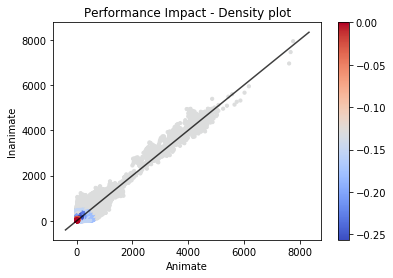

In [70]:
#Density Plot for Animate/Inanimate

print(x.shape,y.shape,z.shape)
fig, ax = plt.subplots()
cs = ax.scatter(x, y, c=z, s=10,cmap='coolwarm')
cbar = fig.colorbar(cs)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
plt.xlabel('Animate')
plt.ylabel('Inanimate')
plt.title('Performance Impact - Density plot')
plt.savefig('../../results/'+str(method)+'_results_density.png', format='png',dpi=200)

In [26]:
keras.backend.clear_session()
gc.collect()
#del model

32195

In [108]:
%time
layer_info = {}
#Comparing Layer lesions
classes = ['animate','inanimate']

for label in [ana,ina]:
    
    layer_info[label] = {}
    #Before lesion
    #print('Pre-layer-lesioning')
    #print('Label:',label)
    #print('Layer:',layer)

    pred = clf.predict(X_new)
    loc = np.where(pred==label)[0]
    loc_new =[]
    for i in range(len(loc)):
        temp = np.where(pred_kmeans==loc[i])[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((13555712,)))
    print('no', len(loc_new))
    model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    print('No Lesion: ',dprime)
    layer_info[label]['no'] = dprime   
    keras.backend.clear_session()
    gc.collect()
    del model

    #Before lesion
    #print('Pre-layer-lesioning')
    #print('Label:',label)
    #print('Layer:',layer)

    pred = clf.predict(X_new)
    loc = np.where(pred==label)[0]
    loc_new =[]
    for i in range(len(loc)):
        temp = np.where(pred_kmeans==loc[i])[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((13555712,)))
    lambda_mask[loc_new] = 0.
    print('pre-loc', len(loc_new))
    model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    print('Cluster Only: ',dprime)
    layer_info[label]['pre'] = dprime   
    keras.backend.clear_session()
    gc.collect()
    del model

    #After lesion
    #print('Pre-layer-lesioning')
    #print('Label:',label)
    #print('Layer:',layer)

    pred = clf.predict(X_new)
    loc = np.where(pred==label)[0]
    loc_new =[]
    for i in range(len(loc)):
        temp = np.where(pred_kmeans==loc[i])[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((13555712,)))
    number = len(loc_new)
    if label == ana:
        lambda_mask[index_ana[0:number]] = 0.
    elif label == ina:
        lambda_mask[index_ina[0:number]] = 0.

    print('lrp-loc', len(loc_new))
    model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    print('LRP Only: ',dprime)
    layer_info[label]['lrp'] = dprime   
    keras.backend.clear_session()
    gc.collect()
    del model

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
no 4327280
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 31 39 0.20512820512820518 0.7948717948717948
No Lesion:  -0.1282051282051283
pre-loc 4327280
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cluster Only:  0.0
lrp-loc 4327280
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
LRP Only:  0.0
no 1134240
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 31 39 0.20512820512820518 0.7948717948717948
No Lesion:  -0.1282051282051283
pre-loc 1134240
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 26 39 0.33333333333333337 0.6666666666666666
Cluster Only:  -0.2564102564102565
lrp-loc 1134240
animate 0 39 1.0 0.0
inanimate 1 39 0.9743589743589743 0.02564102564102566
LRP Only:  0.02564102564102566


[1 2] [0.0, 0.0]


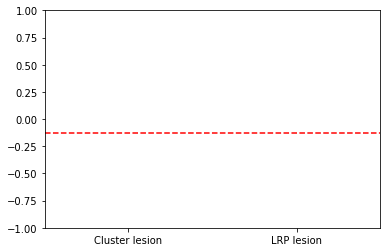

In [109]:
X = np.arange(1,3)
Y =[]
for item in ['pre','lrp']:
    Y.append(layer_info[ana][item])

plt.axhline(y=layer_info[ana]['no'] , color='r', linestyle='--')
plt.ylim([-1,1])
plt.xticks(X,('Cluster lesion','LRP lesion'))
plt.bar(X,Y)
print(X,Y)

[1 2 3 4] [-0.02564102564102566, 0.0, 0.0, 0.0]


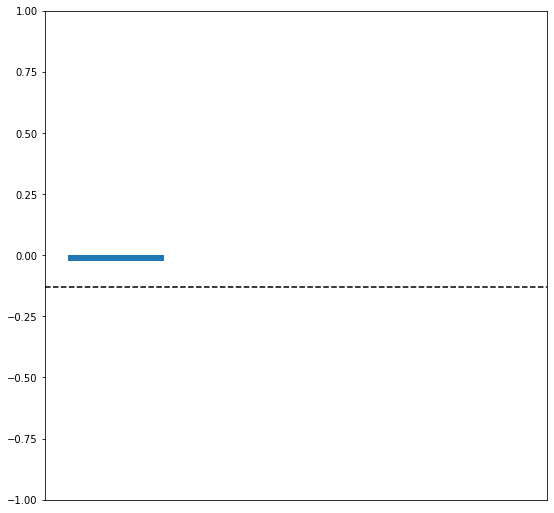

In [116]:
X = np.arange(1,5)
Y =[]
for item in [-0.02564102564102566,0.,0.,0.0]:
    Y.append(item)

plt.figure(figsize=((9,9)))
plt.axhline(y= -0.1282051282051283 , color='black', linestyle='--')
plt.ylim([-1,1])
plt.xticks([])
#plt.xticks(X,('Cluster','LRP-Z','Gradient','LRPPrestFlatA'))
plt.bar(X,Y)
print(X,Y)
plt.savefig('../../results/lesion_animate_lrp.png', type='png', dpi=500)

[1 2] [-0.2564102564102565, 0.02564102564102566]


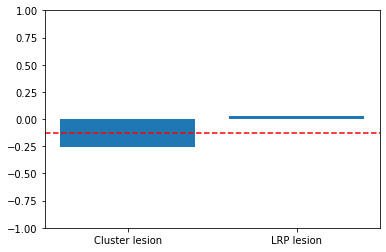

In [110]:
X = np.arange(1,3)
Y =[]
for item in ['pre','lrp']:
    Y.append(layer_info[ina][item])

plt.axhline(y=layer_info[ina]['no'] , color='r', linestyle='--')
plt.ylim([-1,1])
plt.xticks(X,('Cluster lesion','LRP lesion'))
plt.bar(X,Y)
print(X,Y)

[1 2 3 4] [-0.2564102564102565, -0.17948717948717952, 0.02564102564102566, -0.15384615384615385]


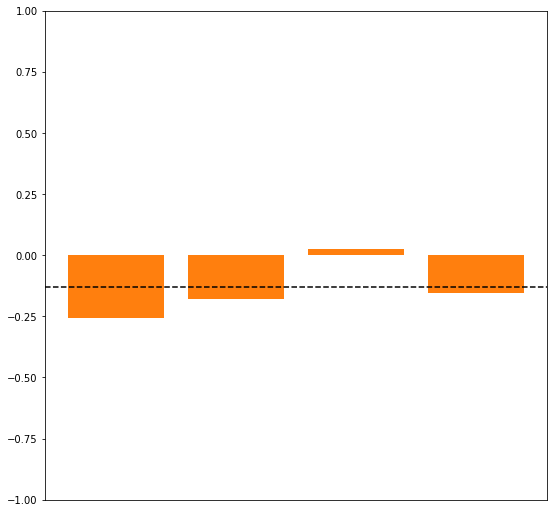

In [118]:
X = np.arange(1,5)
Y =[]
for item in [-0.2564102564102565,-0.17948717948717952,0.02564102564102566, -0.15384615384615385]:
    Y.append(item)

plt.figure(figsize=((9,9)))
plt.axhline(y= -0.1282051282051283 , color='black', linestyle='--')
plt.ylim([-1,1])
plt.xticks([])
#plt.xticks(X,('Cluster','LRP-Z','Gradient','LRPPrestFlatA'))
plt.bar(X,Y,color='C1')
print(X,Y)
plt.savefig('../../results/lesion_inanimate_lrp.png', type='png', dpi=500)

(-0.5, 223.5, 223.5, -0.5)

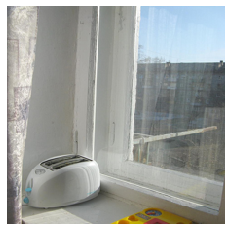

In [50]:
image_list_valid = '../../data/pkl/inanimate_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))
        
size = 224
ret = PIL.Image.open(im_valid_test[19])
ret = ret.resize((size, size))
ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
if ret.ndim == 2:
    ret.resize((size, size, 1))
    ret = np.repeat(ret, 3, axis=-1)
#ret = ret.transpose((2, 0, 1))
plt.imshow(ret/255)
plt.axis('off')

In [40]:
#Actual Model
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)


In [45]:
#Actual Model - Cluster Lesioned
label=13
pred = clf.predict(X_new)
loc = np.where(pred==label)[0]
loc_new =[]
for i in range(len(loc)):
    temp = np.where(pred_kmeans==loc[i])[0]
    loc_new.extend(temp)

lambda_mask = np.ones(shape=((13555712,)))
lambda_mask[loc_new] = 0.
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)


In [46]:
im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_valid_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_valid_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))
    
flag  = 0
for i in range(len(true_valid_wids)):
    flag  = 0
    temp = true_valid_wids[i]
    for j in predicted_valid_wids[i][0:5]:
        if j == temp:
            flag = 1
            break
    if flag == 1:
        print(i,'1 - Correct')
    else:
        print(i,'0 - Wrong')

0 1 - Correct
1 0 - Wrong
2 0 - Wrong
3 1 - Correct
4 1 - Correct
5 1 - Correct
6 0 - Wrong
7 1 - Correct
8 1 - Correct
9 1 - Correct
10 1 - Correct
11 0 - Wrong
12 1 - Correct
13 0 - Wrong
14 1 - Correct
15 1 - Correct
16 1 - Correct
17 1 - Correct
18 0 - Wrong
19 0 - Wrong
20 1 - Correct
21 1 - Correct
22 1 - Correct
23 1 - Correct
24 1 - Correct
25 1 - Correct
26 1 - Correct
27 0 - Wrong
28 0 - Wrong
29 1 - Correct
30 1 - Correct
31 1 - Correct
32 1 - Correct
33 0 - Wrong
34 0 - Wrong
35 1 - Correct
36 1 - Correct
37 0 - Wrong
38 0 - Wrong


In [46]:
'''

Label 6 - Inanimate - Without Lesion

0 1 - Correct
1 1 - Correct
2 0 - Wrong
3 1 - Correct
4 1 - Correct
5 1 - Correct
6 0 - Wrong
7 1 - Correct
8 1 - Correct
9 1 - Correct
10 1 - Correct
11 0 - Wrong
12 1 - Correct
13 0 - Wrong
14 1 - Correct
15 1 - Correct
16 1 - Correct
17 1 - Correct
18 1 - Correct
19 1 - Correct
20 1 - Correct
21 1 - Correct
22 1 - Correct
23 1 - Correct
24 1 - Correct
25 1 - Correct
26 1 - Correct
27 0 - Wrong
28 0 - Wrong
29 1 - Correct
30 1 - Correct
31 1 - Correct
32 1 - Correct
33 1 - Correct
34 1 - Correct
35 1 - Correct
36 1 - Correct
37 0 - Wrong
38 0 - Wrong

Label 6 - Inanimate - With Lesion

0 1 - Correct
1 0 - Wrong
2 0 - Wrong
3 1 - Correct
4 1 - Correct
5 1 - Correct
6 0 - Wrong
7 1 - Correct
8 1 - Correct
9 1 - Correct
10 1 - Correct
11 0 - Wrong
12 1 - Correct
13 0 - Wrong
14 1 - Correct
15 1 - Correct
16 1 - Correct
17 1 - Correct
18 0 - Wrong
19 0 - Wrong
20 1 - Correct
21 1 - Correct
22 1 - Correct
23 1 - Correct
24 1 - Correct
25 1 - Correct
26 1 - Correct
27 0 - Wrong
28 0 - Wrong
29 1 - Correct
30 1 - Correct
31 1 - Correct
32 1 - Correct
33 0 - Wrong
34 0 - Wrong
35 1 - Correct
36 1 - Correct
37 0 - Wrong
38 0 - Wrong
'''

'\nLabel 6 - Inanimate\n0 1 - Correct\n1 1 - Correct\n2 0 - Wrong\n3 1 - Correct\n4 1 - Correct\n5 1 - Correct\n6 0 - Wrong\n7 1 - Correct\n8 1 - Correct\n9 1 - Correct\n10 1 - Correct\n11 0 - Wrong\n12 1 - Correct\n13 0 - Wrong\n14 1 - Correct\n15 1 - Correct\n16 1 - Correct\n17 1 - Correct\n18 1 - Correct\n19 0 - Wrong\n20 1 - Correct\n21 1 - Correct\n22 0 - Wrong\n23 1 - Correct\n24 1 - Correct\n25 0 - Wrong\n26 1 - Correct\n27 0 - Wrong\n28 0 - Wrong\n29 1 - Correct\n30 1 - Correct\n31 1 - Correct\n32 1 - Correct\n33 0 - Wrong\n34 0 - Wrong\n35 1 - Correct\n36 1 - Correct\n37 0 - Wrong\n38 0 - Wrong\n'

In [47]:
# Strip softmax layer
output = []
temp = model.outputs[0]
layer, node_index, tensor_index = temp._keras_history
layer_wo_act = innvestigate.utils.keras.graph.copy_layer_wo_activation(layer)
output.append(layer_wo_act(layer.get_input_at(node_index)))

#Updated Model
model= keras.models.Model(inputs=model.inputs,outputs=output,name=model.name)

#Analyzer Object
analyzer = innvestigate.create_analyzer("lrp.z", model,reverse_keep_tensors=True,allow_lambda_layers=True)

In [48]:
x = preprocess_input(ret[None])
a = analyzer.analyze(x)

(-0.5, 223.5, 223.5, -0.5)

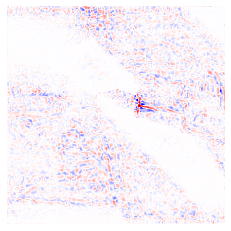

In [49]:
# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.axis('off')

In [44]:
keras.backend.clear_session()
gc.collect()
#del model

2571